In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyproj
from grid import Grid  ## NEDAS.grid module for handling regular/irregular grids


In [2]:
##read surface wind from ERA5 dataset, on a regular lon/lat grid, call it grid1
from netCDF4 import Dataset
path = '/cluster/work/users/yingyue/data/ERA5/001'
t_index = 152 ##time index for 2007-1-20 00:00
f = Dataset(path+'/ERA5_u10_y2007.nc')
u = f['u10'][t_index, ...].data
f = Dataset(path+'/ERA5_v10_y2007.nc')
v = f['v10'][t_index, ...].data
wind = np.array([u, v])

##ERA5 data map projection is just lon/lat
proj1 = pyproj.Proj('+proj=longlat')

##get x,y coordinates of the lon/lat grid1
lat = f['latitude'][:].data
lon = f['longitude'][:].data
x1, y1 = np.meshgrid(lon, lat)

##define grid1, longitude (x) dimension is cyclic, latitude (y) contains a pole at 90 (index=0)
grid1 = Grid(proj1, x1, y1, cyclic_dim='x', pole_dim='y', pole_index=(0,))


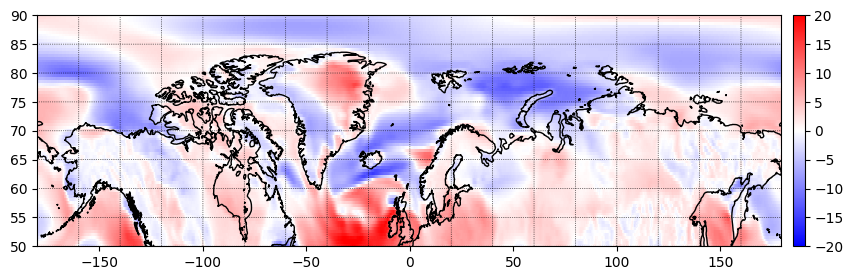

In [3]:
##you can visualize data on the native grid using routines provided by the grid object
fig, ax = plt.subplots(1, 1, figsize=(10,3))

##plot the u-wind on lon/lat grid
grid1.plot_field(ax, wind[0,:], vmin=-20, vmax=20, cmap='bwr')

##show the land for a complete map
grid1.plot_land(ax, color=None, linecolor='k')


In [3]:
##read in sea ice states from nextsim output, on irregular mesh, call it grid2
from models.nextsim import read_data
filename = '/cluster/work/users/yingyue/data/nextsim_ens/001/field_20070120T000000Z.bin'

##get variables: sea ice thickness and velocity
sit = read_data(filename, 'M_thick')
siv = read_data(filename, 'M_VT').reshape((2, -1))

##nextsim uses polar stereographic projection
proj2 = pyproj.Proj(proj='stere', a=6378273, b=6356889.448910593, lat_0=90., lon_0=-45., lat_ts=60.)

##x, y coordinates for grid2
x2 = read_data(filename.replace('field','mesh'), 'Nodes_x')
y2 = read_data(filename.replace('field','mesh'), 'Nodes_y')

##triangulation of the mesh
triangles = read_data(filename.replace('field','mesh'), 'Elements').reshape((-1, 3)) - 1

##define grid2, for regular=False, triangles provides indices for each element's vertices
grid2 = Grid(proj2, x2, y2, regular=False, triangles=triangles)


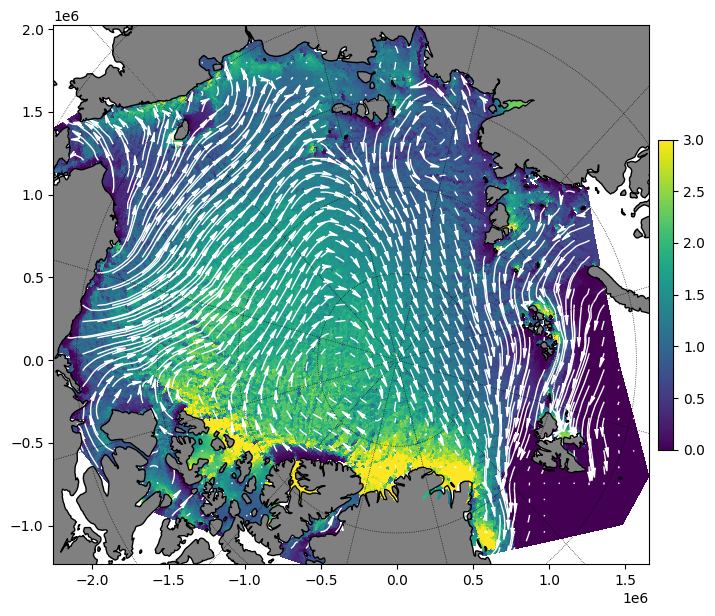

In [5]:
##visualize data on the native mesh
fig, ax = plt.subplots(1, 1, figsize=(8,7))

##show thickness as shadings, the plot_field function calls plt.tripcolor for irregular mesh
grid2.plot_field(ax, sit, vmin=0, vmax=3, cmap='viridis')

##show ice drift vector field in white arrows
grid2.plot_vectors(ax, siv, linecolor='w')

##show the land with gray color, here we show all the options for plot_land()
grid2.plot_land(ax, color=[.5, .5, .5], linecolor='k', linewidth=1, showgrid=True, dlon=30, dlat=5)


In [9]:
##now we define a regular reference grid, where we gather different variables

##define projection using pyproj.Proj
##make a regular grid in the new projection (in meters)
grid = Grid.regular_grid(pyproj.Proj("+proj=lcc +lon_0=-120 +lat_1=40 +lat_2=60"),
                         -3e6, 3e6, 6e6, 11e6, dx=2e4)

##specify the dst_grid for the two source grid
grid1.dst_grid = grid
grid2.dst_grid = grid

In [10]:
##convert the variables
## is_vector tells the converter that the vector field needs rotation
## method = "linear" (default) or "nearest" for interpolation
wind_ = grid1.convert(wind, is_vector=True, method='linear')
sit_ = grid2.convert(sit)
siv_ = grid2.convert(siv, is_vector=True)


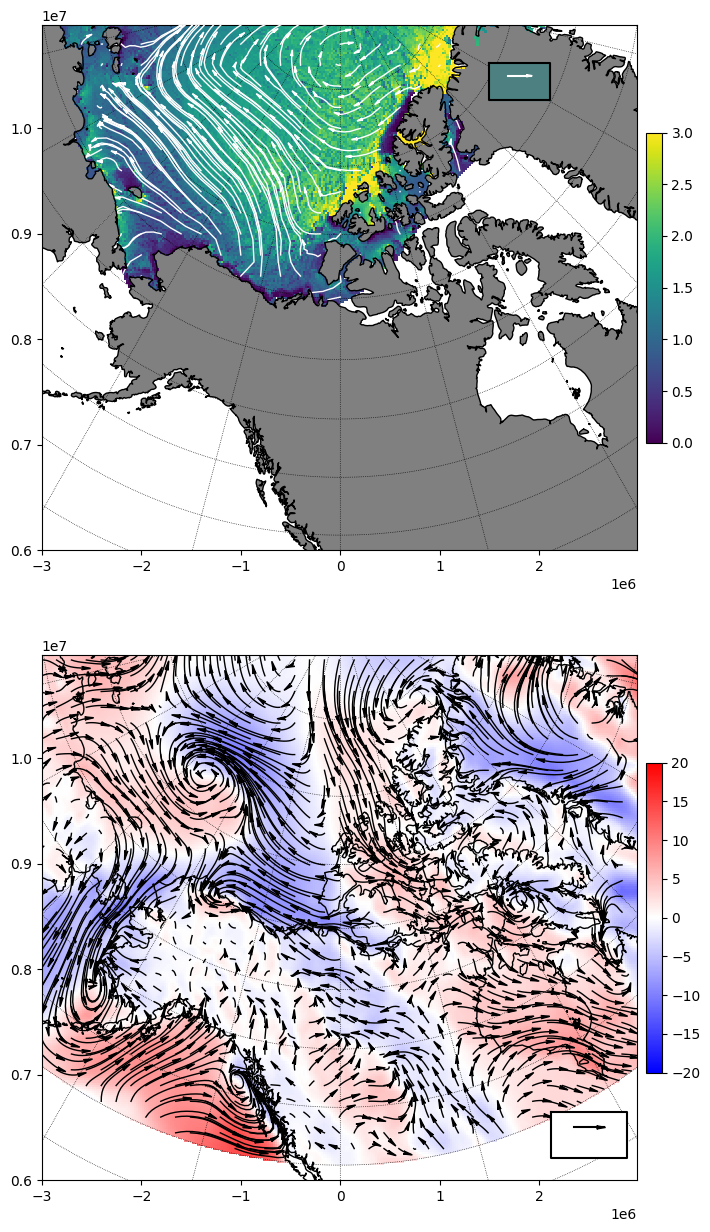

In [8]:
##now we plot some variables from both grid1,grid2 on the reference grid
plt.figure(figsize=(8,15))

##here we show all the parameters for plot_field() and plot_vectors(), the program
##tries to set parameters optimally, see grid.py for more details.

##sea ice properties on top:
ax = plt.subplot(211)
grid.plot_land(ax, color=[.5, .5, .5], linecolor='k')
grid.plot_field(ax, sit_, vmin=0, vmax=3, cmap='viridis')
grid.plot_vectors(ax, siv_, V=0.05, L=2e5, spacing=1, num_steps=10,
                  showref=True, ref_xy=(1.8e6, 10.5e6), refcolor=[.3, .5, .5],
                  linecolor='w', linewidth=1, showhead=True, headwidth=0.1, headlength=0.3)

##wind on bottom:
ax = plt.subplot(212)
grid.plot_land(ax, linecolor='k')
grid.plot_field(ax, wind_[0,:], vmin=-20, vmax=20, cmap='bwr')
grid.plot_vectors(ax, wind_, showref=True, ref_xy=(2.5e6, 6.5e6))
